In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

### Load, process and visualize the data

In [52]:
ys_ik = pd.read_csv('../data/trajectories/steady_state/observations_steady_state_beta_seed0.csv')
max_seed = 8
max_targeted_seed = 3
for seed in range(1, max_seed+1):
    ys_ik = pd.concat([ys_ik, pd.read_csv(f'../data/trajectories/steady_state/observations_steady_state_beta_seed{seed}.csv')])
for seed in range(0, max_targeted_seed+1):
    ys_ik = pd.concat([ys_ik, pd.read_csv(f'../data/trajectories/steady_state/observations_steady_state_targeted_seed{seed}.csv')])
ys_ik = ys_ik.drop(columns='ID')
rest_positions = np.array([0.1005, -0.10698, 0.10445, -0.10302, -0.20407, 0.10933, 0.10581, -0.32308, 0.10566])
ys_ik = ys_ik - rest_positions

In [46]:
ys_ik.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3
0,0.000620,0.001099,-0.001206,0.201693,0.001716,0.000409,-0.012020,0.001579,-0.001975
1,-0.004637,0.000242,-0.000401,0.191458,0.001510,-0.000603,-0.017016,0.002664,0.011038
2,0.003550,0.000982,0.003488,0.206801,0.002077,0.006857,-0.036921,0.013250,-0.012135
3,-0.005735,0.001495,0.002928,0.192746,0.002911,0.001675,-0.043387,0.009237,0.001858
4,0.000227,0.001135,0.006175,0.196900,0.007194,0.021983,-0.048843,0.021676,0.048776


In [47]:
len(ys_ik)

1380

In [48]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# Steady-state data

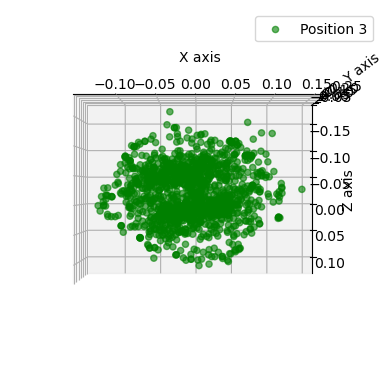

In [53]:
plt.close('all')

# Enable the ipympl backend for interactive plots
# %matplotlib widget

z_dataframes = [ys_ik]
position_colors = ['r', 'b', 'g']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for z_df in z_dataframes:
    x1, y1, z1 = z_df['x1'], z_df['y1'], z_df['z1']
    x2, y2, z2 = z_df['x2'], z_df['y2'], z_df['z2']
    x3, y3, z3 = z_df['x3'], z_df['y3'], z_df['z3']
    # ax.scatter(x1, y1, z1, color=position_colors[0], label='Position 1', alpha=0.6)
    # ax.scatter(x2, y2, z2, color=position_colors[1], label='Position 2', alpha=0.6)
    ax.scatter(x3, y3, z3, color=position_colors[2], label='Position 3', alpha=0.6)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Adjust the view so that y-axis is upwards
ax.view_init(elev=180, azim=-90)
ax.legend()
set_axes_equal(ax)

In [58]:
def check_control_inputs(u_opt, u_opt_previous):
    # reject vector norms of u that are too large
    tip_range, mid_range, base_range = 0.65, 0.35, 0.3 #changed tip range to 0.55 to account for circle samples

    u1, u2, u3, u4, u5, u6 = u_opt[0], u_opt[1], u_opt[2], u_opt[3], u_opt[4], u_opt[5]

    # First we clip to max and min values
    u1 = np.clip(u1, -tip_range, tip_range)
    u6 = np.clip(u6, -tip_range, tip_range)
    u2 = np.clip(u2, -mid_range, mid_range)
    u5 = np.clip(u5, -mid_range, mid_range)
    u3 = np.clip(u3, -base_range, base_range)
    u4 = np.clip(u4, -base_range, base_range)

    # Compute control input vectors
    u1_vec = u1 * np.array([-np.cos(15 * np.pi/180), np.sin(15 * np.pi/180)])
    u2_vec = u2 * np.array([np.cos(45 * np.pi/180), np.sin(45 * np.pi/180)])
    u3_vec = u3 * np.array([-np.cos(15 * np.pi/180), -np.sin(15 * np.pi/180)])
    u4_vec = u4 * np.array([-np.cos(75 * np.pi/180), np.sin(75 * np.pi/180)])
    u5_vec = u5 * np.array([np.cos(45 * np.pi/180), -np.sin(45 * np.pi/180)])
    u6_vec = u6 * np.array([-np.cos(75 * np.pi/180), -np.sin(75 * np.pi/180)])

    # Calculate the norm based on the constraint
    vector_sum = (
        0.75 * (u3_vec + u4_vec) +
        1.0 * (u2_vec + u5_vec) +
        1.4 * (u1_vec + u6_vec)
    )
    norm_value = np.linalg.norm(vector_sum)

    # Check the constraint: if the constraint is met, then keep previous control command
    if norm_value > 0.9: #(was 0.7)
        print(f'Sample {u_opt} got rejected')
        u_opt = u_opt_previous
    else:
        # Else the clipped command is published
        u_opt = np.array([u1, u2, u3, u4, u5, u6])

    return u_opt

In [59]:
data_dir = os.getenv('TRUNK_DATA', '/home/trunk/Documents/trunk-stack/stack/main/data')
us_df = pd.read_csv(data_dir + '/trajectories/steady_state/control_inputs_targeted_seed4.csv')
u_opt_previous = np.array([0,0,0,0,0,0])
us_df = us_df.drop(columns=['ID'])
us = us_df.to_numpy()


rejection_count = 0
for u in us:
    u_opt = check_control_inputs(u, u_opt_previous)
    if u_opt.all == u_opt_previous.all:
        rejection_count += 1
        print(f'rejection count = {rejection_count}')

Sample [ 0.64670298  0.00472322  0.04726844  0.0214816   0.01977288 -0.02839105] got rejected
rejection count = 1
Sample [ 0.33119728 -0.00951748 -0.01688255  0.00721388  0.03454436  0.56095928] got rejected
rejection count = 2
Sample [ 0.24286332 -0.04153384  0.00972666 -0.02545463  0.02325934  0.59225232] got rejected
rejection count = 3
Sample [-0.63366945 -0.04090894  0.00570821  0.03561838  0.03841979  0.10912296] got rejected
rejection count = 4
Sample [-0.63730507 -0.01246599 -0.0470226   0.00377817  0.04458283 -0.03742079] got rejected
rejection count = 5
Sample [-0.06530446  0.01101064 -0.02712061 -0.00739822 -0.0306485  -0.64255871] got rejected
rejection count = 6
Sample [ 0.10211679  0.03767815  0.03598813  0.03339769 -0.00737288 -0.62059748] got rejected
rejection count = 7
Sample [ 0.385134    0.00712342 -0.03805181  0.02961844 -0.0176248  -0.4899796 ] got rejected
rejection count = 8


# Dynamic data visualization

In [6]:
y_decay_300g = pd.read_csv('../data/trajectories/dynamic/observations_decay_300g.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/trajectories/dynamic/observations_decay_300g.csv'

In [ ]:
y_decay_300g.head()

,ID,x1,y1,z1,x2,y2,z2,x3,y3,z3
0,0,0.100173,-0.107995,0.106393,0.101732,-0.206740,0.108745,0.100305,-0.326480,0.097787
1,0,0.100182,-0.107982,0.106378,0.101721,-0.206750,0.108749,0.100284,-0.326482,0.097777
2,0,0.100179,-0.107984,0.106385,0.101708,-0.206740,0.108748,0.100264,-0.326477,0.097776
3,0,0.100154,-0.107985,0.106391,0.101694,-0.206756,0.108759,0.100250,-0.326480,0.097775
4,0,0.100165,-0.107986,0.106391,0.101685,-0.206744,0.108757,0.100233,-0.326491,0.097776


In [ ]:
# Group the data by ID (each are a separate trajectory)
y_decay_300g_trajs = y_decay_300g.groupby('ID')

NameError: name 'y_decay_300g_trajs' is not defined

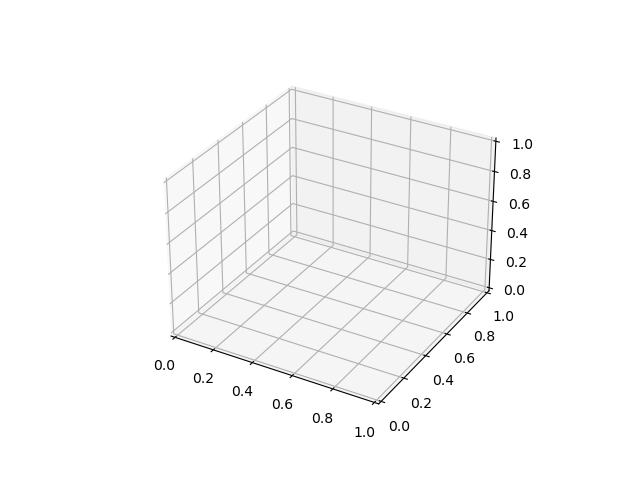

In [13]:
plt.close('all')

# Enable the ipympl backend for interactive plots
%matplotlib widget

position_colors = ['r', 'b', 'g']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for id, y_traj in y_decay_300g_trajs:
    x1, y1, z1 = y_traj['x1'], y_traj['y1'], y_traj['z1']
    x2, y2, z2 = y_traj['x2'], y_traj['y2'], y_traj['z2']
    x3, y3, z3 = y_traj['x3'], y_traj['y3'], y_traj['z3']
    ax.scatter(x1, y1, z1, color=position_colors[0], label='Position 1', alpha=0.6)
    ax.scatter(x2, y2, z2, color=position_colors[1], label='Position 2', alpha=0.6)
    ax.scatter(x3, y3, z3, color=position_colors[2], label='Position 3', alpha=0.6)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Adjust the view so that y-axis is upwards
ax.view_init(elev=100, azim=-45, roll=45)
# ax.legend()
set_axes_equal(ax)

In [17]:
# Load data
us_df = pd.read_csv('../data/trajectories/steady_state/control_inputs_uniform.csv')
ys_df = pd.read_csv('../data/trajectories/steady_state/observations_steady_state_src_demo_17oct24.csv')
print(us_df.head())
print(ys_df.head())

rest_positions = np.array([0.1005, -0.10698, 0.10445, 0.10302, -0.20407, 0.10933, 0.10581, -0.32308, 0.10566])
ys_df = ys_df - rest_positions

   ID    u1    u2    u3    u4    u5    u6
0   0 -0.15 -0.25 -0.35 -0.15 -0.25 -0.35
1   1 -0.15 -0.25 -0.35 -0.15 -0.25  0.00
2   2 -0.15 -0.25 -0.35 -0.15 -0.25  0.35
3   3 -0.15 -0.25 -0.35 -0.15  0.00 -0.35
4   4 -0.15 -0.25 -0.35 -0.15  0.00  0.00
         x1        y1        z1        x2        y2        z2        x3  \
0  0.107059 -0.104323  0.101977  0.116542 -0.195033  0.117761  0.158514   
1  0.107828 -0.105214  0.101619  0.116393 -0.197476  0.110741  0.154204   
2  0.104319 -0.104857  0.100888  0.105971 -0.198226  0.098051  0.112724   
3  0.106059 -0.105418  0.101940  0.119186 -0.198815  0.111211  0.161131   
4  0.104930 -0.105705  0.100850  0.114474 -0.200890  0.105525  0.154165   

         y3        z3  
0 -0.287180  0.158053  
1 -0.301953  0.113356  
2 -0.296631  0.047529  
3 -0.297934  0.130002  
4 -0.305079  0.104934  


In [18]:
# Convert to numpy
ys = ys_df.to_numpy()
n = ys.shape[0]
us = us_df.to_numpy()[:n, 1:]

# Split in train and test data
n_train = int(n * 0.85)
n_test = n - n_train

us_train = us[:n_train]
us_test = us[n_train:]

ys_train = ys[:n_train]
ys_test = ys[n_train:]

In [19]:
# Simple least squares to find G in u = G*y
G = np.linalg.lstsq(ys_train, us_train, rcond=None)[0].T

# Save G
np.save('../data/models/ik/y2u_src_demo.npy', G)

In [20]:
# Predict u_test using the learned G
us_pred = ys_test @ G.T

In [21]:
# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(np.square(us_test - us_pred)))
print(f"Root Mean Squared Error on the test data: {rmse}")

Root Mean Squared Error on the test data: 0.18003877332473717


In [22]:
# For sense of scale, calculate the mean of |us|
mean_control_input = np.mean(np.abs(us))
print(f"Mean of the control inputs: {mean_control_input}")

Mean of the control inputs: 0.16452614379084968
